In [1]:
import os
import models
import pandas as pd
import heartpy as hp
import data_utils as utils
import matplotlib.pyplot as plt

# Loading Empatica Data

## Loading Pilot Dataset

In [2]:
utils.check_if_files_unzipped('pilot')

Data already unzipped
Data path exists: pilot


In [3]:
data_path = "{0}/pilot/pilot".format(os.getcwd())

In [4]:
participants = os.listdir(data_path)

In [5]:
participants

['2', '3', '6', '5', '10', '4', '0', '1', '9', '8', '7']

In [6]:
step = 8 # this is number of samples between start of extracted snippets
sampling = 64 # this is sample rate of the device, in case of empatica this is 64 Hz
seconds = 30 # the length of the extracted signal snippet in seconds
window =  seconds *  sampling
x_train, y_train = utils.cogwear_pilot_load_dataset(data_path, participants[:-2], step=step, device='empatica',
                                                    sampling=sampling, window=window)

In [7]:
len(x_train), len(y_train)

(32356, 32356)

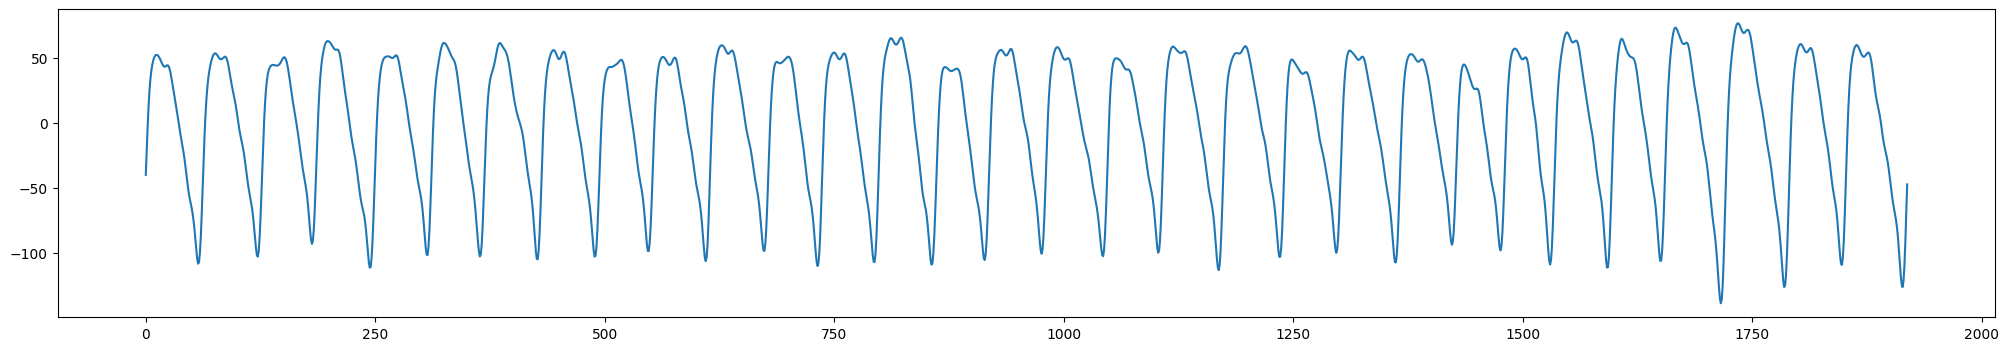

The class: 0.0


In [8]:
i = 20000
plt.figure(figsize=(25, 4))
plt.plot(x_train[i])
plt.show()
print("The class: {0}".format(y_train[i]))
# 0 is baseline and 1 is cognitive load 

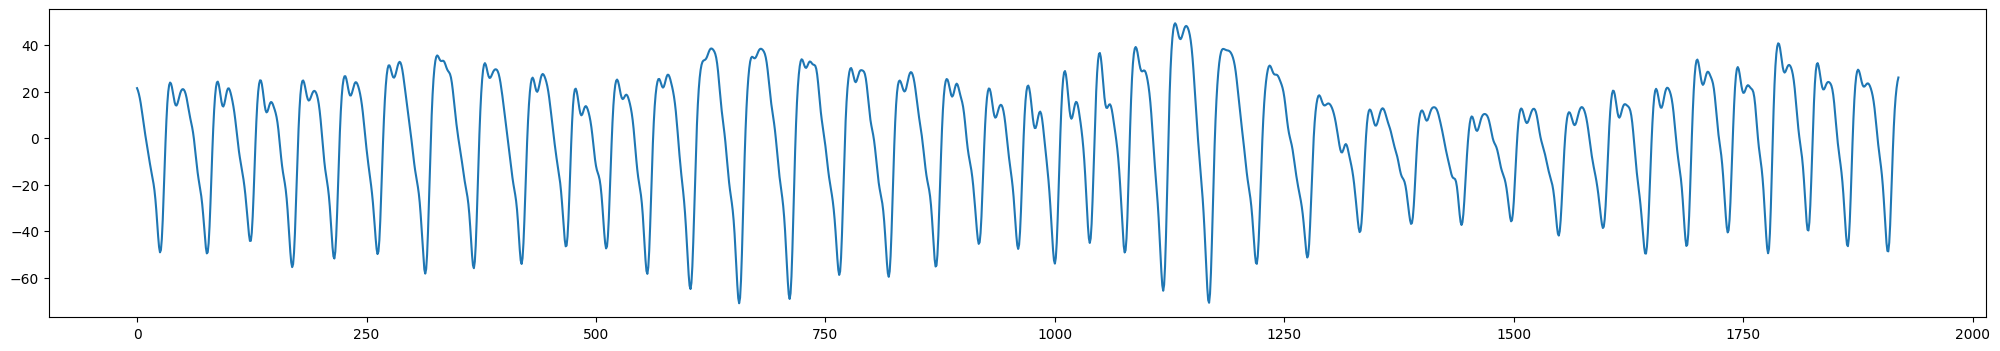

The class: 0.0


In [9]:
i = 23500
plt.figure(figsize=(25, 4))
plt.plot(x_train[i])
plt.show()
print("The class: {0}".format(y_train[i]))
# 0 is baseline and 1 is cognitive load 

## Loading Empatica PPG signal from Gamification Experiment


In [10]:
survey_data_path = 'survey_gamification/survey_gamification'
utils.check_if_files_unzipped(survey_data_path)

Data already unzipped
Data path exists: survey_gamification/survey_gamification


In [11]:
survey_exp_participants = os.listdir(survey_data_path)

In [12]:
survey_exp_participants

['22', '15', '14', '12', '24', '17', '23', '11', '20', '13', '21', '18', '16']

### Loading data capture during calibration tasks

In [13]:
cond = 'pre' #there are two sessions 'pre' and 'post'
cognitiveLoad, baseline = utils.cogwear_survey_load_participant_calibration(survey_data_path, survey_exp_participants[0],
                                              cond, device='empatica', sampling_frequency=sampling)

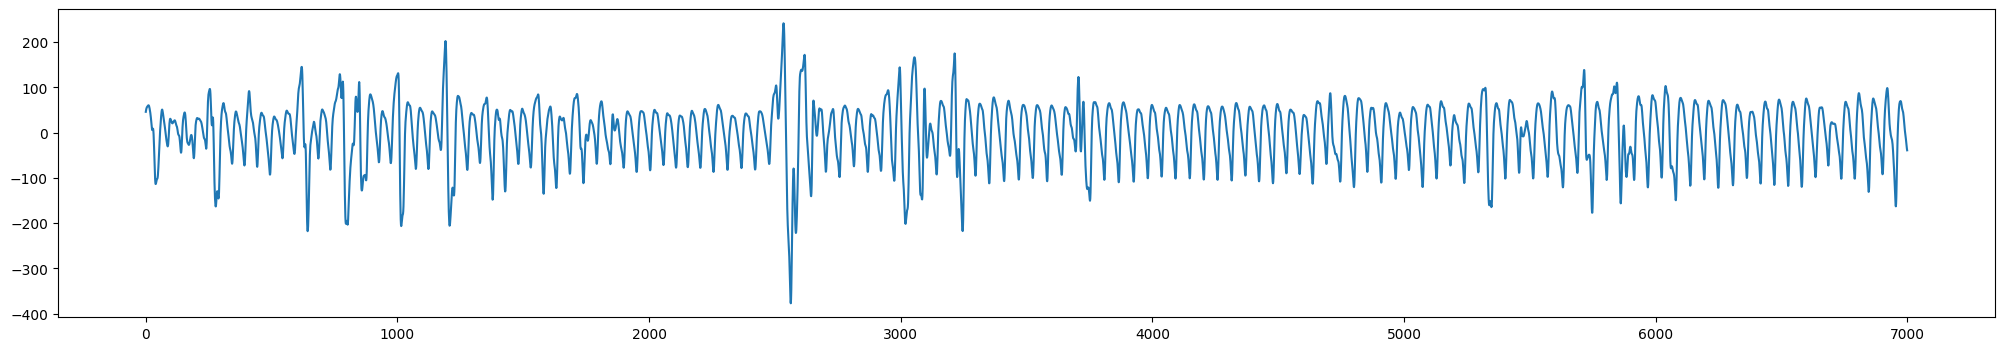

In [14]:
plt.figure(figsize=(25, 4))
plt.plot(cognitiveLoad[1000:8000])
plt.show()


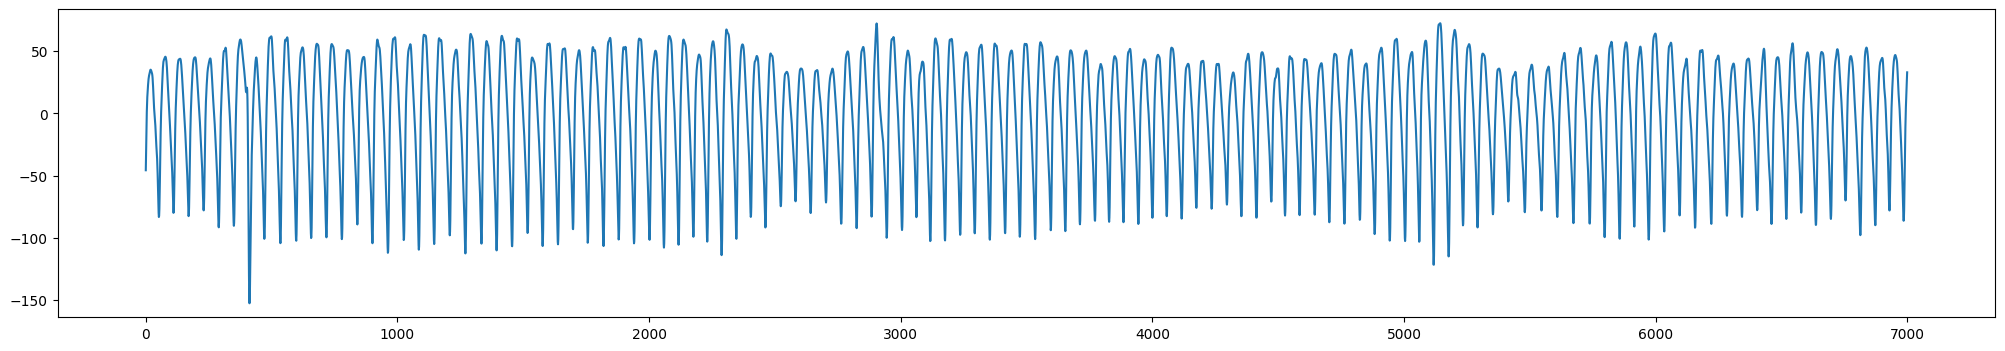

In [15]:
plt.figure(figsize=(25, 4))
plt.plot(baseline[1000:8000])
plt.show()

### Loading data captured during mobile survey completion

In [16]:
survey_bvp_signal = pd.read_csv('{0}/{1}/{2}/survey/empatica_bvp.csv'.format(survey_data_path,
                                                                             survey_exp_participants[0], cond))

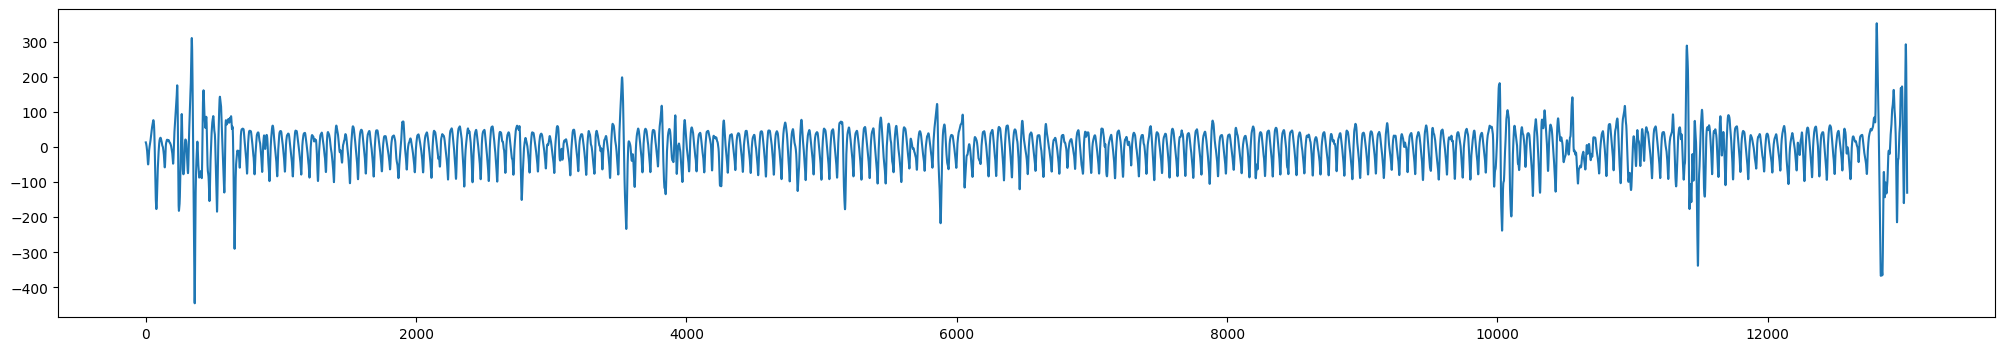

In [17]:
plt.figure(figsize=(25, 4))
plt.plot(survey_bvp_signal.bvp.values)
plt.show()

# Simple 1D CNN Model

In [18]:
number_of_channels = 1
number_of_classes_to_predict = 2
model = models.create_model('baseline', window, number_of_channels, number_of_classes_to_predict, lr=0.001)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1918, 16)          64        
                                                                 
 conv1d_1 (Conv1D)           (None, 1916, 8)           392       
                                                                 
 dropout (Dropout)           (None, 1916, 8)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 958, 8)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7664)              0         
                                                                 
 dense (Dense)               (None, 30)                229950    
                                                        